#  과제1. 수어 번역기 파이프라인

* 데이터 출처 : https://www.kaggle.com/datasets/datamunge/sign-language-mnist?select=sign_mnist_train

## 1.환경준비

### (1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
import cv2
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.backend import clear_session
from keras.optimizers import Adam

np.set_printoptions(linewidth=np.inf)

In [2]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (2) 데이터로딩

In [3]:
path = ''
file = 'sign_language.csv'

data = pd.read_csv(file)
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,22,186,186,185,185,185,184,185,184,184,...,171,122,65,62,215,180,99,47,31,25
1,24,175,177,179,181,181,182,182,182,183,...,202,202,201,200,199,197,195,193,191,189
2,6,187,187,187,187,187,186,187,186,186,...,45,23,25,34,41,43,39,40,43,35
3,2,169,169,169,170,169,170,169,169,169,...,204,203,200,199,198,196,194,193,191,190
4,21,153,165,170,179,190,198,203,206,213,...,161,122,132,96,75,63,37,43,70,66


In [4]:
data.shape

(8000, 785)

### (3) class names
* label이 0 ~ 27 까지의 숫자로 표현됩니다.
* 수어 중에서 J(9) 와 Z(27)는 손을 움직이면서 표현해야 하므로, 여기서는 제외합니다.
* 숫자로 레이블링 된 것을, 나중에 문자 변환하기 위해 문자로 된 리스트를 생성합니다.

In [5]:
import string
class_names = list(string.ascii_lowercase)
class_names = np.array(class_names)
len(class_names), class_names

(26,
 array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], dtype='<U1'))

## 2 데이터 살펴보기

### (1) 데이터 한 건을 2차원으로 변환하고 그림 그리기

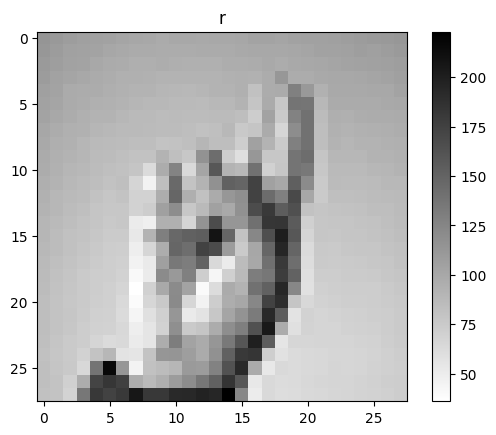

In [6]:
# 아래 숫자를 바꿔가며 화면에 그려 봅시다.
n = 100
sign_fig = data.iloc[n, 1:].values
sign_fig = sign_fig.reshape(28, 28)

sign = class_names[data.iloc[n,0]]

plt.title(sign)
plt.imshow(255-sign_fig, cmap=plt.cm.binary)
plt.colorbar()
plt.show()

## 3.데이터 준비

* 주어진 데이터셋
    * 2차원 데이터셋, 1차원 데이터포인트(분석단위, 예측단위) 입니다. 
    * 흑백 이미지데이터
    * 이 데이터로부터 데이터 준비작업을 수행합니다.
        * 데이터 분할1 : x, y
        * 데이터 분할2 : train, validation
        * 만약 CNN으로 모델링을 한다면, shape를 맞춰야 합니다. (n, 28, 28, 1) 
        * scaling
* 그러나 운영에서 발생될 데이터는 이미지 한장 한장 입니다. 이미지 한장, 한장 들어온다면 어떻게 데이터가 처리되어야 할까요?(Data Pipeline 구성)

### (1) 데이터 분할1 : x, y 나누기

In [7]:
target = 'label'
x = data.drop(target, axis=1)
y = data.loc[:, target]

### (2) 데이터 분할2 : train, validation

* train : val : test = 5000 : 2000 : 1000
* 여기서 test set은 파이프라인 점검을 위한 용도로 사용합니다.

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1000, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=2000, random_state=42)

In [9]:
x_train.shape, x_val.shape, x_test.shape

((5000, 784), (2000, 784), (1000, 784))

In [10]:
x_train, y_train = x_train.values, y_train.values
x_val, y_val = x_val.values, y_val.values

### (3) shape 맞추기 n, 28,28,1

* reshape
    * x_train.shape : (-1, 28, 28, 1)
    * x_val.shape : (-1, 28, 28, 1)

In [11]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

In [12]:
x_train.shape, x_val.shape

((5000, 28, 28, 1), (2000, 28, 28, 1))

### (4) Scaling : Min-Max

* 0-255 값으로 되어 있는 데이터를 0-1사이 값으로 변환
* x_train, x_test를 그냥 255로 나누면 됨

In [13]:
x_train = x_train / 255
x_val = x_val / 255

x_train.max(), x_train.min(), x_val.max(), x_val.min()

(1.0, 0.0, 1.0, 0.0)

## 4.모델링

### (1) 모델 설계

In [14]:
clear_session()

model = Sequential()

model.add(Input(shape=(28, 28, 1)))
model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', strides=(1, 1), activation='relu'))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(26, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 256)       2560      
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 512)               102760960 
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 26)                13338     
                                                                 
Total params: 102,776,858
Trainable params: 102,776,858
Non-trainable params: 0
_________________________________________________________________


### (2) 학습

In [15]:
history = model.fit(x_train, y_train, 
                    epochs=10, 
                    validation_split=0.2).history

Epoch 1/10
125/125 [==============================] - 88s 701ms/step - loss: 2.7975 - val_loss: 1.4936
Epoch 2/10
125/125 [==============================] - 113s 907ms/step - loss: 1.1813 - val_loss: 0.7064
Epoch 3/10
125/125 [==============================] - 131s 1s/step - loss: 0.6316 - val_loss: 0.3998
Epoch 4/10
125/125 [==============================] - 130s 1s/step - loss: 0.3728 - val_loss: 0.2234
Epoch 5/10
125/125 [==============================] - 116s 925ms/step - loss: 0.2351 - val_loss: 0.1634
Epoch 6/10
125/125 [==============================] - 129s 1s/step - loss: 0.1504 - val_loss: 0.0946
Epoch 7/10
125/125 [==============================] - 128s 1s/step - loss: 0.1006 - val_loss: 0.0748
Epoch 8/10
125/125 [==============================] - 132s 1s/step - loss: 0.0749 - val_loss: 0.0351
Epoch 9/10
125/125 [==============================] - 139s 1s/step - loss: 0.0541 - val_loss: 0.0391
Epoch 10/10
125/125 [==============================] - 135s 1s/step - loss: 0.0487 

### (3) 학습결과 그래프

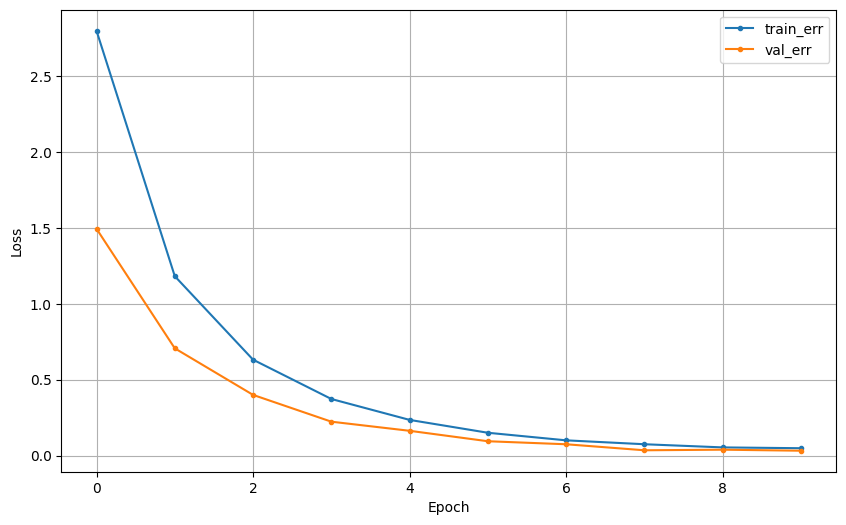

In [16]:
dl_history_plot(history)

### (4) 예측 및 검증

In [17]:
pred = model.predict(x_val)

63/63 [==============================] - 3s 39ms/step


In [18]:
pred = model.predict(x_val)
pred_1 = pred.argmax(axis=1)

63/63 [==============================] - 3s 40ms/step


In [19]:
print(accuracy_score(y_val,pred_1))
print('-'*60)
print(confusion_matrix(y_val, pred_1))

0.994
------------------------------------------------------------
[[ 73   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  78   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  69   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  80   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  73   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  89   0   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  85   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  75   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  77   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  87 

In [20]:
print(classification_report(class_names[y_val], class_names[pred_1]))

              precision    recall  f1-score   support

           a       1.00      1.00      1.00        73
           b       1.00      1.00      1.00        78
           c       1.00      1.00      1.00        69
           d       1.00      1.00      1.00        80
           e       1.00      1.00      1.00        73
           f       0.99      0.97      0.98        92
           g       1.00      1.00      1.00        85
           h       0.96      1.00      0.98        75
           i       1.00      1.00      1.00        77
           k       1.00      0.98      0.99        89
           l       1.00      1.00      1.00        94
           m       0.98      1.00      0.99        88
           n       1.00      1.00      1.00        79
           o       1.00      1.00      1.00        86
           p       1.00      1.00      1.00        63
           q       1.00      1.00      1.00       101
           r       0.97      1.00      0.98        94
           s       1.00    

## 5.저장하기

* 여기서는 joblib을 이용하여 모델과 데이터셋을 저장하겠습니다.

### (1) 모델 저장하기

In [21]:
joblib.dump(model, 'model.pkl')

['model.pkl']

### (2) 모델 로딩하기
* 로딩시 model2로 저장합니다.

In [22]:
model2 = joblib.load('model.pkl')

### (3) test 셋으로 예측하고 평가해보기

* test 셋에 필요한 전처리는 다음과 같습니다.
    * 넘파이 어레이로 변환
    * 4차원 데이터셋으로 변환
    * 스케일링

In [23]:
# 넘파이 어레이로 변환
new_dataset = x_test.values

# 4차원 데이터셋
new_dataset = new_dataset.reshape(-1, 28, 28, 1)

# 스케일링
new_dataset = new_dataset / 255

In [24]:
# 예측하고 평가하기
pred = model2.predict(new_dataset)
pred_1 = pred.argmax(axis=1)

print(accuracy_score(y_test, pred_1))
print('-'*60)
print(confusion_matrix(y_test, pred_1))
print('-'*60)
print(classification_report(class_names[y_test], class_names[pred_1]))

32/32 [==============================] - 1s 44ms/step
0.989
------------------------------------------------------------
[[49  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 32  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 31  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 36  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 45  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 46  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 45  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 45  0  0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 46  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 53  0  0  0  0  0  

## 6.Data Pipeline 구성

### (1) 라이브러리 로딩

In [25]:
# 파이프라인에서 필요한 라이브러리/함수
import pandas as pd
import numpy as np
import cv2
import joblib

### (2) 테스트 데이터 로딩
* 제공받은 이미지로 테스트 해보기
* 직접 찍은 사진으로 테스트 해보기

In [26]:
# 파일 열기
path = 'test image/'
file = 'v.png'
filename = path + file

img = cv2.imread(filename)
cv2.imshow('img', img)

cv2.waitKey(0)  # 키보드 입력 대기
cv2.destroyAllWindows()  # 키보드 입력이 있으면 이미지 창 닫기

### (3) Data Pipeline에 포함되어야 할 절차
* 이미지 크기 맞추기
* 흑백이미지
* 스케일링

#### 1)이미지 읽을 때 흑백으로 읽기

In [27]:
# 파일 열기
img = cv2.imread(filename , cv2.IMREAD_GRAYSCALE)

# 조회는 파이프라인 불필요
print(img.shape)
cv2.imshow('img', img)
cv2.waitKey(0)  # 키보드 입력 대기
cv2.destroyAllWindows()  # 키보드 입력이 있으면 이미지 창 닫기

(260, 228)


#### 2)이미지 크기를 28, 28, 1 로 맞추기
* 이미지 크기를 조절하는 방법은 크게 두가지 입니다.
    * numpy 
    * opencv의 resize 함수 이용

In [28]:
# 크기 조절하기
img = cv2.resize(img, (28, 28))

# 조회는 파이프라인 불필요
print(img.shape)
cv2.imshow('img', img)
cv2.waitKey(0)  # 키보드 입력 대기
cv2.destroyAllWindows()  # 키보드 입력이 있으면 이미지 창 닫기

(28, 28)


In [29]:
# 입력데이터 형식을 갖추기
test_sign = img.reshape(1,28,28,1)

#### 3)스케일링

In [30]:
test_sign = test_sign / 255.

#### 4)모델 로딩하기

In [31]:
model2 = joblib.load('model.pkl')

#### 5)예측하기

In [32]:
pred = model2.predict(test_sign)
pred_1 = pred.argmax(axis=1)
print(class_names[pred_1])

1/1 [==============================] - 0s 94ms/step
['v']


### (4) 하나의 셀로 합치기

* 코드를 하나로 모으기

In [33]:
# 파이프라인에서 필요한 라이브러리/함수
import pandas as pd
import numpy as np
import cv2
import joblib

# class names 준비
class_names = list(string.ascii_lowercase)
class_names = np.array(class_names)

# 파일 로딩
file = 'test image/v.png'

# 흑백으로 읽기
img = cv2.imread(file , cv2.IMREAD_GRAYSCALE)

# 크기 조정
img = cv2.resize(img, (28, 28))

# input shape 맞추기
test_sign = img.reshape(1,28,28,1)

# 스케일링
test_sign = test_sign / 255.

# 모델 로딩
model2 = joblib.load('model.pkl')

# 예측
pred = model.predict(test_sign)
pred_1 = pred.argmax(axis=1)
print(class_names[pred_1])

1/1 [==============================] - 0s 75ms/step
['v']
